<a href="https://colab.research.google.com/github/ASEM000/Physics-informed-neural-network-in-JAX/blob/main/%5B7%5D_PDE_LAPLACE_FO_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q optax 
!pip install -q pytreeclass

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 KB 1.2 MB/s eta 0:00:00


https://ml4physicalsciences.github.io/2022/files/NeurIPS_ML4PS_2022_67.pdf

# FO-PINN

step=1000		loss=1.929e-03
step=2000		loss=1.167e-03
step=3000		loss=9.410e-04
step=4000		loss=7.757e-04
step=5000		loss=6.352e-04
step=6000		loss=5.227e-04
step=7000		loss=4.575e-04
step=8000		loss=3.885e-04
step=9000		loss=4.232e-04
step=10000		loss=3.992e-04


<Figure size 720x720 with 0 Axes>

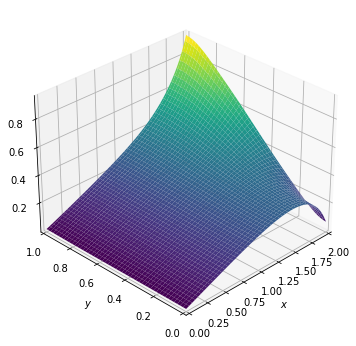

In [2]:
import jax 
import jax.numpy as jnp
import jax.random as jr
import pytreeclass as pytc
import optax
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import functools as ft

@pytc.treeclass
class Linear:
    weight:jnp.ndarray
    bias:jnp.ndarray

    def __init__(self,in_features,out_features,key:jr.KeyArray=jr.PRNGKey(0)):
        lb, ub = -(1 / jnp.sqrt(in_features)), (1 / jnp.sqrt(in_features))
        self.weight = lb + (ub-lb) * jr.uniform(key,shape=(in_features,out_features))
        self.bias = jr.uniform(key,(out_features,))
    
    def __call__(self, x):
        return x @ self.weight + self.bias
    
@pytc.treeclass
class FNN:
    layers: tuple[int,...] 

    def __init__(self, layers, *,activation):
        keys = jax.random.split(jax.random.PRNGKey(0),len(layers)-1)
        self.layers = tuple(Linear(in_dim, out_dim, key) for in_dim, out_dim,key in zip(layers[:-1], layers[1:], keys))
        self.activation = activation
    
    def __call__(self, x,y):
        X = jnp.concatenate([x,y],axis=-1)
        *layers, last = self.layers
        for layer in layers:
            X = self.activation(layer(X))
        return last(X)

N_b = 100  # boundary points
N_r = 10_000 # collocation points

ymin,ymax=0. ,1.
xmin,xmax = 0.,2.

'''boundary conditions'''

bk1,bk2,bk3,bk4,r1k,r2k = jax.random.split(jax.random.PRNGKey(0),6)


# P[0,y] = 0
yb1 = jr.uniform(bk1,minval=ymin,maxval=ymax,shape=(N_b,1))
xb1 = jnp.zeros_like(yb1)
bc1 = jnp.zeros_like(yb1)
BC1 = jnp.concatenate([xb1,yb1,bc1],axis=1)

# P[2,y] = y
yb2 = jr.uniform(bk2,minval=ymin,maxval=ymax,shape=(N_b,1))
xb2 = jnp.ones_like(yb2) *2
bc2 = yb2
BC2 = jnp.concatenate([xb2,yb2,bc2],axis=1)

# P_y[x,0] = 0
xb3 = jr.uniform(bk3,minval=xmin,maxval=xmax,shape=(N_b,1))
yb3 = jnp.zeros_like(xb3)
bc3 = jnp.zeros_like(xb3)
BC3 = jnp.concatenate([xb3,yb3,bc3],axis=1)

# P_y[x,1] = 0
xb4 = jr.uniform(bk4,minval=xmin,maxval=xmax,shape=(N_b,1))
yb4 = jnp.ones_like(xb4)
bc4 = jnp.zeros_like(xb4)
BC4 = jnp.concatenate([xb4,yb4,bc4],axis=1)

BCs = [BC1,BC2,BC3,BC4]

#collocation points
yc = jr.uniform(r1k,minval=ymin,maxval=ymax,shape=(N_r,1))
xc = jr.uniform(r2k,minval=xmin,maxval=xmax,shape=(N_r,1))
Xc = jnp.concatenate([xc,yc],axis=1) 


fig = plt.figure(figsize=(10,10))
# plt.scatter(xb1, yb1, c=bc1, marker='x', vmin=0, vmax=2,label='P[0,y] = 0',cmap=cm.jet)
# plt.scatter(xb2, yb2, c=bc2, marker='^', vmin=0, vmax=2,label='P[2,y] = y',cmap=cm.jet)
# plt.scatter(xb3, yb3, c=bc3, marker='*', vmin=0, vmax=2,label='P_y[x,0] = 0',cmap=cm.jet)
# plt.scatter(xb4, yb4, c=bc4, marker='o', vmin=0, vmax=2,label='P_y[x,1] = 0',cmap=cm.jet)


cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)


# plt.scatter(x_c, y_c, c='k', marker='.', alpha=0.2,label='Collocation points',cmap=cm.jet)
# plt.xlabel('$x$')
# plt.ylabel('$y$')

# plt.title('Positions of IC,BC and collocation points');
# plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
# plt.legend(loc='center right')


def diff(func, *args, **kwargs):
    """grad of sum"""
    @ft.partial(jax.grad, *args, **kwargs)
    @ft.wraps(func)
    def sum_func(*ar, **kw):
        return jnp.sum(func(*ar, **kw))
    return sum_func

def MSE(true,pred):
  return jnp.mean((true-pred)**2)

@ft.partial(jax.grad, has_aux=True)
def loss_func(NN:FNN,Xc:jax.Array,BCs:list[jax.Array]):
    # FO-PINN predicts Tx,Ty in addition to T 
    # to reduce the laplace equation to a first order PDE
    xc,yc = jnp.split(Xc,2,axis=-1)
    T = lambda xc,yc : NN(xc,yc)[:,[0]]
    Tx = lambda xc,yc : NN(xc,yc)[:,[1]]
    Ty = lambda xc,yc : NN(xc,yc)[:,[2]]
    
    # compat loss
    T_hat_x = diff(T, argnums=0)
    T_hat_y = diff(T, argnums=1)

    comp_loss = MSE( Tx(xc,yc) , T_hat_x(xc,yc))
    comp_loss += MSE( Ty(xc,yc), T_hat_y(xc,yc))

    # pde loss.
    # note we differentiate once
    Txx = diff(Tx, argnums=0)
    Tyy = diff(Ty, argnums=1)

    pde_loss = MSE(Txx(xc,yc) + Tyy(xc,yc), 0)

    # boundary loss
    BC1, BC2, BC3, BC4 = BCs

    x,y,bc = jnp.split(BC1,3,axis=-1)
    b_loss = MSE(bc , T(x,y))

    x,y,bc = jnp.split(BC2,3,axis=-1)
    b_loss += MSE(bc , T(x,y))

    x,y,bc = jnp.split(BC3,3,axis=-1)
    b_loss += MSE(bc, Ty(x,y))

    x,y,bc = jnp.split(BC4,3,axis=-1)
    b_loss += MSE(bc, Ty(x,y))

    loss = comp_loss + pde_loss + b_loss

    return loss, loss



optim = optax.adam(1e-2)


@jax.jit
def train_step(NN:FNN,optstate, Xc:jax.Array,BCs:list[jax.Array]):
    dNN,loss = loss_func(NN,Xc,BCs)
    updates, optstate = optim.update(dNN, optstate)
    NN = optax.apply_updates(NN, updates)
    return NN,optstate,loss


def train(Xc:jax.Array,BCs:list[jax.Array],epochs:int):
    NN = FNN(layers=(2,8,8,8,8,3),activation=jax.nn.tanh)
    optstate = optim.init(NN)
    for i in range(1,epochs+1):
        NN,optstate,loss = train_step(NN,optstate,Xc,BCs)
        if i % 1_000 == 0:
            print(f"step={i:003d}\t\tloss={loss:.3e}")
    return NN


NN = train(Xc,BCs,10_000)

def plot2D(T,X, p):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, X, p[:],  cmap=cm.viridis)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.view_init(30,225)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

N=100
x = jnp.linspace(0, 2, N)
y = jnp.linspace(0, 1, N)
X,Y = jnp.meshgrid(x, y, indexing="ij")
T = NN(X.flatten().reshape(-1,1),Y.flatten().reshape(-1,1))[:,0].reshape(N,N)

plot2D(X,Y,T)

# Standard PINN

step=1000		loss=1.514e-03
step=2000		loss=1.806e-03
step=3000		loss=1.313e-03
step=4000		loss=9.662e-04
step=5000		loss=8.974e-04
step=6000		loss=8.341e-04
step=7000		loss=7.717e-04
step=8000		loss=1.755e-03
step=9000		loss=6.790e-04
step=10000		loss=1.029e-03


<Figure size 720x720 with 0 Axes>

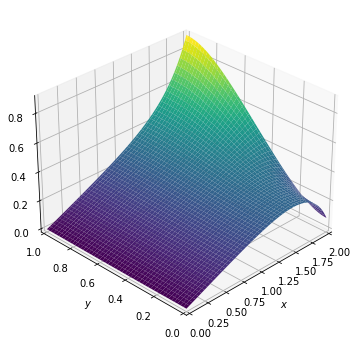

In [7]:
import jax 
import jax.numpy as jnp
import jax.random as jr
import pytreeclass as pytc
import optax
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import functools as ft

@pytc.treeclass
class Linear:
    weight:jnp.ndarray
    bias:jnp.ndarray

    def __init__(self,in_features,out_features,key:jr.KeyArray=jr.PRNGKey(0)):
        lb, ub = -(1 / jnp.sqrt(in_features)), (1 / jnp.sqrt(in_features))
        self.weight = lb + (ub-lb) * jr.uniform(key,shape=(in_features,out_features))
        self.bias = jr.uniform(key,(out_features,))
    
    def __call__(self, x):
        return x @ self.weight + self.bias
    
@pytc.treeclass
class FNN:
    layers: tuple[int,...] 

    def __init__(self, layers, *,activation):
        keys = jr.split(jr.PRNGKey(0),len(layers)-1)
        self.layers = tuple(Linear(in_dim, out_dim, key) for in_dim, out_dim, key in zip(layers[:-1], layers[1:], keys))
        self.activation = activation
    
    def __call__(self, x,y):
        X = jnp.concatenate([x,y],axis=-1)
        *layers, last = self.layers
        for layer in layers:
            X = self.activation(layer(X))
        return last(X)

N_b = 100  # boundary points
N_r = 10_000 # collocation points

ymin,ymax=0. ,1.
xmin,xmax = 0.,2.

'''boundary conditions'''

bk1,bk2,bk3,bk4,r1k,r2k = jax.random.split(jax.random.PRNGKey(0),6)


# P[0,y] = 0
yb1 = jr.uniform(bk1,minval=ymin,maxval=ymax,shape=(N_b,1))
xb1 = jnp.zeros_like(yb1)
bc1 = jnp.zeros_like(yb1)
BC1 = jnp.concatenate([xb1,yb1,bc1],axis=1)

# P[2,y] = y
yb2 = jr.uniform(bk2,minval=ymin,maxval=ymax,shape=(N_b,1))
xb2 = jnp.ones_like(yb2) *2
bc2 = yb2
BC2 = jnp.concatenate([xb2,yb2,bc2],axis=1)

# P_y[x,0] = 0
xb3 = jr.uniform(bk3,minval=xmin,maxval=xmax,shape=(N_b,1))
yb3 = jnp.zeros_like(xb3)
bc3 = jnp.zeros_like(xb3)
BC3 = jnp.concatenate([xb3,yb3,bc3],axis=1)

# P_y[x,1] = 0
xb4 = jr.uniform(bk4,minval=xmin,maxval=xmax,shape=(N_b,1))
yb4 = jnp.ones_like(xb4)
bc4 = jnp.zeros_like(xb4)
BC4 = jnp.concatenate([xb4,yb4,bc4],axis=1)

BCs = [BC1,BC2,BC3,BC4]

#collocation points
yc = jr.uniform(r1k,minval=ymin,maxval=ymax,shape=(N_r,1))
xc = jr.uniform(r2k,minval=xmin,maxval=xmax,shape=(N_r,1))
Xc = jnp.concatenate([xc,yc],axis=1) 


fig = plt.figure(figsize=(10,10))
# plt.scatter(xb1, yb1, c=bc1, marker='x', vmin=0, vmax=2,label='P[0,y] = 0',cmap=cm.jet)
# plt.scatter(xb2, yb2, c=bc2, marker='^', vmin=0, vmax=2,label='P[2,y] = y',cmap=cm.jet)
# plt.scatter(xb3, yb3, c=bc3, marker='*', vmin=0, vmax=2,label='P_y[x,0] = 0',cmap=cm.jet)
# plt.scatter(xb4, yb4, c=bc4, marker='o', vmin=0, vmax=2,label='P_y[x,1] = 0',cmap=cm.jet)


cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)


# plt.scatter(x_c, y_c, c='k', marker='.', alpha=0.2,label='Collocation points',cmap=cm.jet)
# plt.xlabel('$x$')
# plt.ylabel('$y$')

# plt.title('Positions of IC,BC and collocation points');
# plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
# plt.legend(loc='center right')


def diff(func, *args, **kwargs):
    """grad of sum"""
    @ft.partial(jax.grad, *args, **kwargs)
    @ft.wraps(func)
    def sum_func(*ar, **kw):
        return jnp.sum(func(*ar, **kw))
    return sum_func

def MSE(y_true,y_pred):
    return jnp.mean((y_true-y_pred)**2)

@ft.partial(jax.grad, has_aux=True)
def loss_func(NN:FNN,Xc:jax.Array,BCs:list[jax.Array]):
    # FO-PINN predicts Tx,Ty in addition to T 
    # to reduce the laplace equation to a first order PDE
    xc,yc = jnp.split(Xc,2,axis=-1)
    T = NN

    # pde loss.
    # note we differentiate once
    Tx = diff(T, argnums=0)
    Ty = diff(T, argnums=1)
    Txx = diff(Tx, argnums=0)
    Tyy = diff(Ty, argnums=1)

    pde_loss = MSE(Txx(xc,yc) + Tyy(xc,yc),0)

    # boundary loss

    BC1,BC2,BC3,BC4 = BCs

    x,y,bc = jnp.split(BC1,3,axis=-1)
    b_loss = MSE(T(x,y),bc)

    x,y,bc = jnp.split(BC2,3,axis=-1)
    b_loss += MSE(T(x,y),bc)

    x,y,bc = jnp.split(BC3,3,axis=-1)
    b_loss += MSE(Ty(x,y),bc)

    x,y,bc = jnp.split(BC4,3,axis=-1)
    b_loss += MSE(Ty(x,y),bc)

    loss =  pde_loss + b_loss

    return loss, loss



optim = optax.adam(1e-2)


@jax.jit
def train_step(NN:FNN,optstate, Xc:jax.Array,BCs:list[jax.Array]):
    dNN,loss = loss_func(NN,Xc,BCs)
    updates, optstate = optim.update(dNN, optstate)
    NN = optax.apply_updates(NN, updates)
    return NN,optstate,loss


def train(Xc:jax.Array,BCs:list[jax.Array],epochs:int):
    NN = FNN(layers=(2,8,8,8,8,1),activation=jax.nn.tanh)
    optstate = optim.init(NN)
    for i in range(1,epochs+1):
        NN,optstate,loss = train_step(NN,optstate,Xc,BCs)
        if i % 1_000 == 0:
            print(f"step={i:003d}\t\tloss={loss:.3e}")
    return NN


NN = train(Xc,BCs,10_000)

def plot2D(T,X, p):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, X, p[:],  cmap=cm.viridis)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.view_init(30,225)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

N=100
x = jnp.linspace(0, 2, N)
y = jnp.linspace(0, 1, N)
X,Y = jnp.meshgrid(x, y, indexing="ij")
T = NN(X.flatten().reshape(-1,1),Y.flatten().reshape(-1,1))[:,0].reshape(N,N)

plot2D(X,Y,T)

# step=1000		loss=1.514e-03
# step=2000		loss=1.806e-03
# step=3000		loss=1.313e-03
# step=4000		loss=9.662e-04
# step=5000		loss=8.974e-04
# step=6000		loss=8.341e-04
# step=7000		loss=7.717e-04
# step=8000		loss=1.755e-03
# step=9000		loss=6.790e-04
# step=10000    loss=1.029e-03